# modified GCN vs baseline
- This run evaluated both models on 4 cell lines: A375, MCF7 (with healthy) and A549, HT29 (without healthy) \
- random 3 split, 5 epochs each, with es

In [84]:
import re
import glob
import os
import json
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [51]:
def extract_results_from_txt(path):
    with open(path, 'r') as f:
        content = f.read()

    # Use regex to find the list of dicts
    matches = re.findall(r'\[\{.*?\}\]', content, re.DOTALL)
    results = []
    for m in matches:
        try:
            results.append(json.loads(m.replace("'", '"')))  # Fix single quotes to valid JSON
        except json.JSONDecodeError:
            continue
    return results

In [82]:
# note cell lines have to be in the right order!!
def collect_metrics(folder_path, curr_cell_line):
    all_results = []
    for filepath in glob.glob(os.path.join(folder_path, "*txt")):
        info = os.path.basename(filepath).replace(".txt", "").split("_")
        model = info[0]
        pert_mode = info[1]
        metric_raw = extract_results_from_txt(filepath)
        for i in range(len(metric_raw)):
            cell_line = curr_cell_line[i]
            for rep_idx, run in enumerate(metric_raw[i]):
                entry = {
                    "model": model,
                    "perturbation": pert_mode,
                    "cell_line": cell_line,
                    "split": rep_idx + 1
                }
                for split in ["train", "test"]:
                    for metric_name, val in run[split].items():
                        entry[f"{split}_{metric_name}"] = val
                all_results.append(entry)

    df = pd.DataFrame(all_results)
    return df

In [86]:
def process_metrics(df):
    df_avg = df.groupby(["cell_line", "model", "perturbation"]).mean(numeric_only=True).reset_index().drop(columns=["split"])
    df_std = df.groupby(["cell_line", "model", "perturbation"]).std().reset_index().drop(columns=["split"])
    df_std = df_std.add_suffix('_std')
    df_std.rename(columns={
        'cell_line_std': 'cell_line',
        'model_std': 'model',
        'perturbation_std': 'perturbation'
    }, inplace=True)
    df_summary = df_avg.merge(df_std, on=["cell_line", "model", "perturbation"])
    df_summary = df_summary.round(3)
    collapsed_across_celllines = df_summary.groupby(["perturbation", "model"]).mean(numeric_only=True).reset_index()
    collapsed_across_celllines = collapsed_across_celllines.round(3)
    return df_summary, collapsed_across_celllines

In [89]:
def df_summary_stat(df_summary):
    df_long = df_summary.melt(
        id_vars=['cell_line', 'model', 'perturbation'],
        value_vars=[col for col in df_summary.columns if not col.endswith('_std')],
        var_name='metric',
        value_name='value'
    )

    std_cols = df_summary.melt(
        id_vars=['cell_line', 'model', 'perturbation'],
        value_vars=[col for col in df_summary.columns if col.endswith('_std')],
        var_name='metric_std',
        value_name='std'
    )

    std_cols['metric'] = std_cols['metric_std'].str.replace('_std$', '', regex=True)

    df_long = df_long.merge(std_cols[['cell_line', 'model', 'perturbation', 'metric', 'std']],
                            on=['cell_line', 'model', 'perturbation', 'metric'], how='left')
    
    return df_long

In [91]:
def plot_metric(df_long, direction, split):
    import matplotlib.pyplot as plt
    import seaborn as sns

    base_metrics = ['r2_scgen', 'spearman', 'r2']
    plot_metrics = [f'{split}_{direction}_{m}' for m in base_metrics]
    plot_data = df_long[df_long['metric'].isin(plot_metrics)]

    g = sns.catplot(
        data=plot_data,
        x='cell_line',
        y='value',
        hue='model',
        col='metric',
        row='perturbation',
        kind='bar',
        height=4,
        aspect=1,
        ci=None
    )

    # Add error bars + value labels
    for ax, m in zip(g.axes.flat, plot_metrics * len(plot_data['perturbation'].unique())):
        subset = plot_data[plot_data['metric'] == m].reset_index()
        for idx, bar in enumerate(ax.patches):
            if idx >= len(subset): break
            bar_height = bar.get_height()
            std = subset.iloc[idx]['std']
            ax.errorbar(
                bar.get_x() + bar.get_width()/2,
                bar_height,
                yerr=std,
                fmt='none',
                c='black',
                capsize=2
            )
            # Add text label
            ax.text(
                bar.get_x() + bar.get_width()/2,
                bar_height + std + 0.01,  # space above error bar
                f"{bar_height:.2f}",
                ha='center',
                va='bottom',
                fontsize=8,
                rotation=0
            )

    # Plot backward_avg_topk if needed
    if direction == 'backward':
        plot_metrics = [f'{split}_backward_avg_topk']
        plot_data = df_long[df_long['metric'].isin(plot_metrics)]

        g2 = sns.catplot(
            data=plot_data,
            x='cell_line',
            y='value',
            hue='model',
            col='metric',
            row='perturbation',
            kind='bar',
            height=4,
            aspect=1,
            ci=None
        )

        for ax, m in zip(g2.axes.flat, plot_metrics * len(plot_data['perturbation'].unique())):
            subset = plot_data[plot_data['metric'] == m].reset_index()
            for idx, bar in enumerate(ax.patches):
                if idx >= len(subset): break
                bar_height = bar.get_height()
                std = subset.iloc[idx]['std']
                ax.errorbar(
                    bar.get_x() + bar.get_width()/2,
                    bar_height,
                    yerr=std,
                    fmt='none',
                    c='black',
                    capsize=2
                )
                ax.text(
                    bar.get_x() + bar.get_width()/2,
                    bar_height + std + 10,  # adjust for avg_topk scale
                    f"{bar_height:.1f}",
                    ha='center',
                    va='bottom',
                    fontsize=8,
                    rotation=0
                )


In [ ]:
# source of my confusion
baseline previous
Epoch 001 [244.06s], Train loss: 0.0459 (forward: 0.0695, backward: 0.0141), Val loss: 0.0085 (forward: 0.0054, backward: 0.0127) | TRAIN - FORWARD: MSE: 0.0052, MAE: 0.0533, R2: 0.7421, R2 scgen: 0.9963, Spearman: 0.8567 | TRAIN - BACKWARD: MSE: 0.0040, MAE: 0.0463, R2: 0.7837, R2 scgen: 0.8046, Spearman: 0.8838, TopK: 114.4829 | TEST - FORWARD: MSE: 0.0053, MAE: 0.0543, R2: 0.7337, R2 scgen: 0.9960, Spearman: 0.8513 | TEST - BACKWARD: MSE: 0.0041, MAE: 0.0470, R2: 0.7758, R2 scgen: 0.7864, Spearman: 0.8788, TopK: 737.4800
gcnmod 
Epoch 001 [262.39s], Train loss: 0.0193 (forward: 0.0163, backward: 0.0234), Val loss: 0.0089 (forward: 0.0054, backward: 0.0136) | TRAIN - FORWARD: MSE: 0.0052, MAE: 0.0537, R2: 0.7421, R2 scgen: 0.9959, Spearman: 0.8562 | TRAIN - BACKWARD: MSE: 0.0024, MAE: 0.0325, R2: 0.8699, R2 scgen: 0.8908, Spearman: 0.9317, TopK: 497.8872 | TEST - FORWARD: MSE: 0.0053, MAE: 0.0545, R2: 0.7354, R2 scgen: 0.9957, Spearman: 0.8519 | TEST - BACKWARD: MSE: 0.0027, MAE: 0.0341, R2: 0.8564, R2 scgen: 0.8672, Spearman: 0.9224, TopK: 1283.5353
baseline after
Epoch 001 [230.34s], Train loss: 0.0787 (forward: 0.1249, backward: 0.0166), Val loss: 0.0087 (forward: 0.0054, backward: 0.0130) | TRAIN - FORWARD: MSE: 0.0052, MAE: 0.0539, R2: 0.7410, R2 scgen: 0.9966, Spearman: 0.8555 | TRAIN - BACKWARD: MSE: 0.0023, MAE: 0.0318, R2: 0.8779, R2 scgen: 0.8926, Spearman: 0.9387, TopK: 307.5295 | TEST - FORWARD: MSE: 0.0054, MAE: 0.0551, R2: 0.7304, R2 scgen: 0.9964, Spearman: 0.8488 | TEST - BACKWARD: MSE: 0.0025, MAE: 0.0333, R2: 0.8654, R2 scgen: 0.8723, Spearman: 0.9308, TopK: 1265.2572

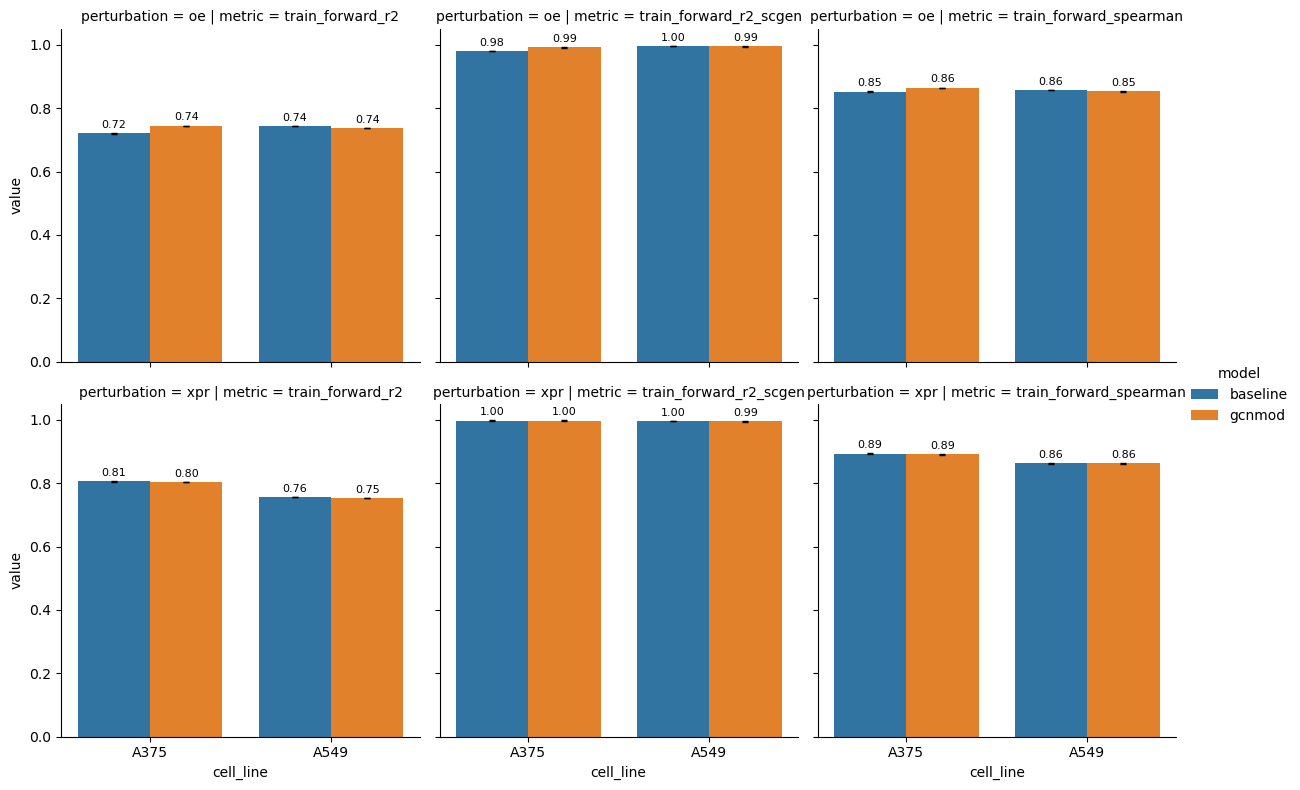

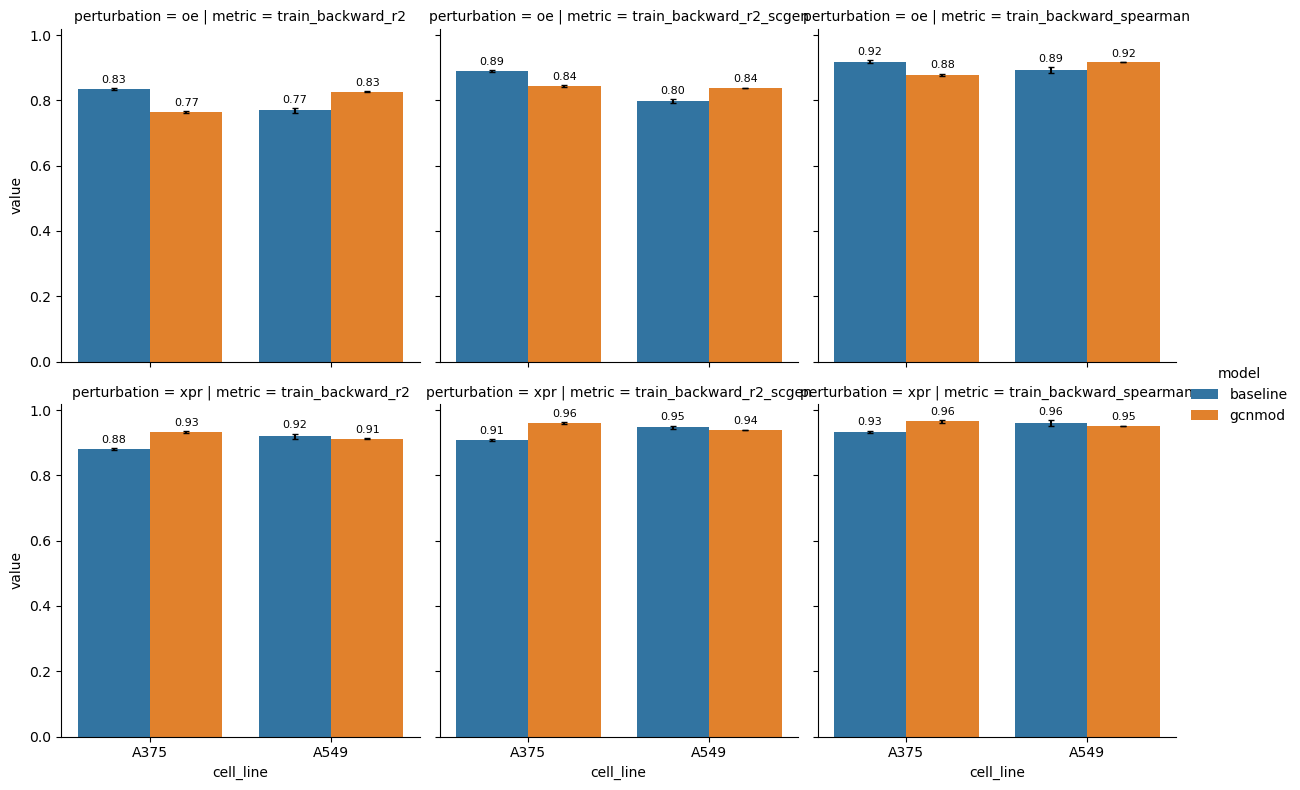

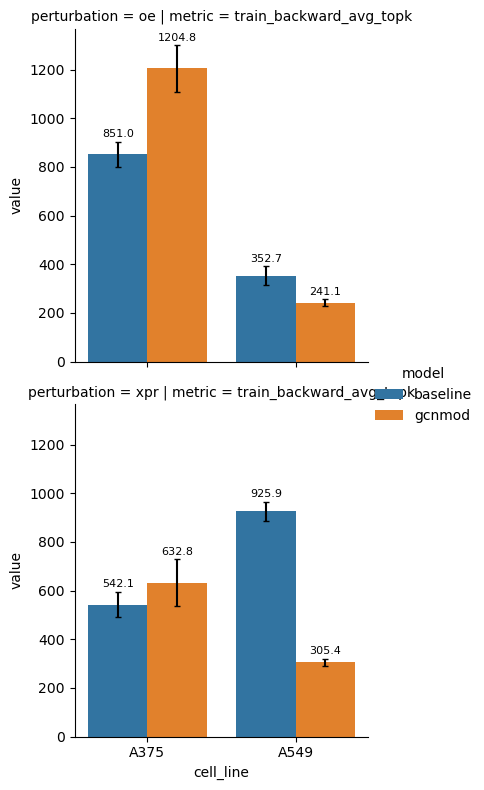

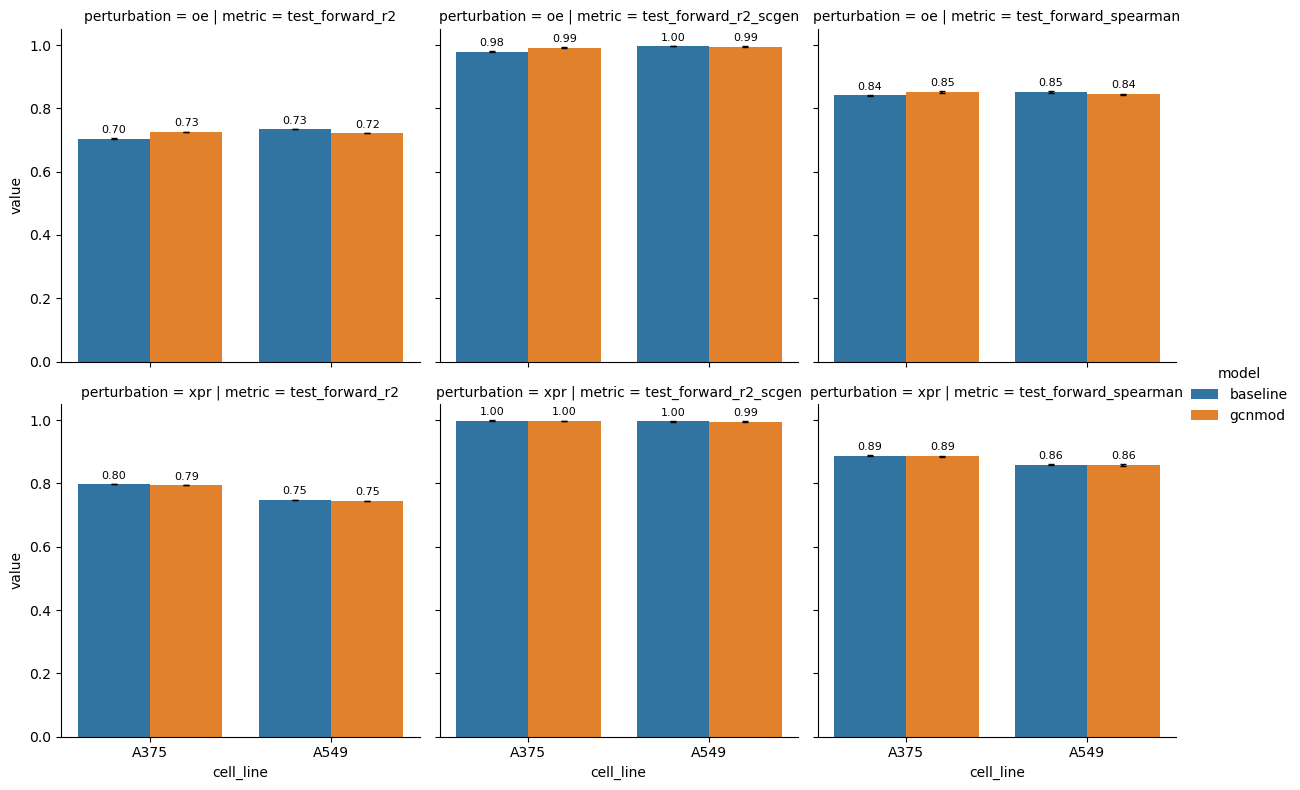

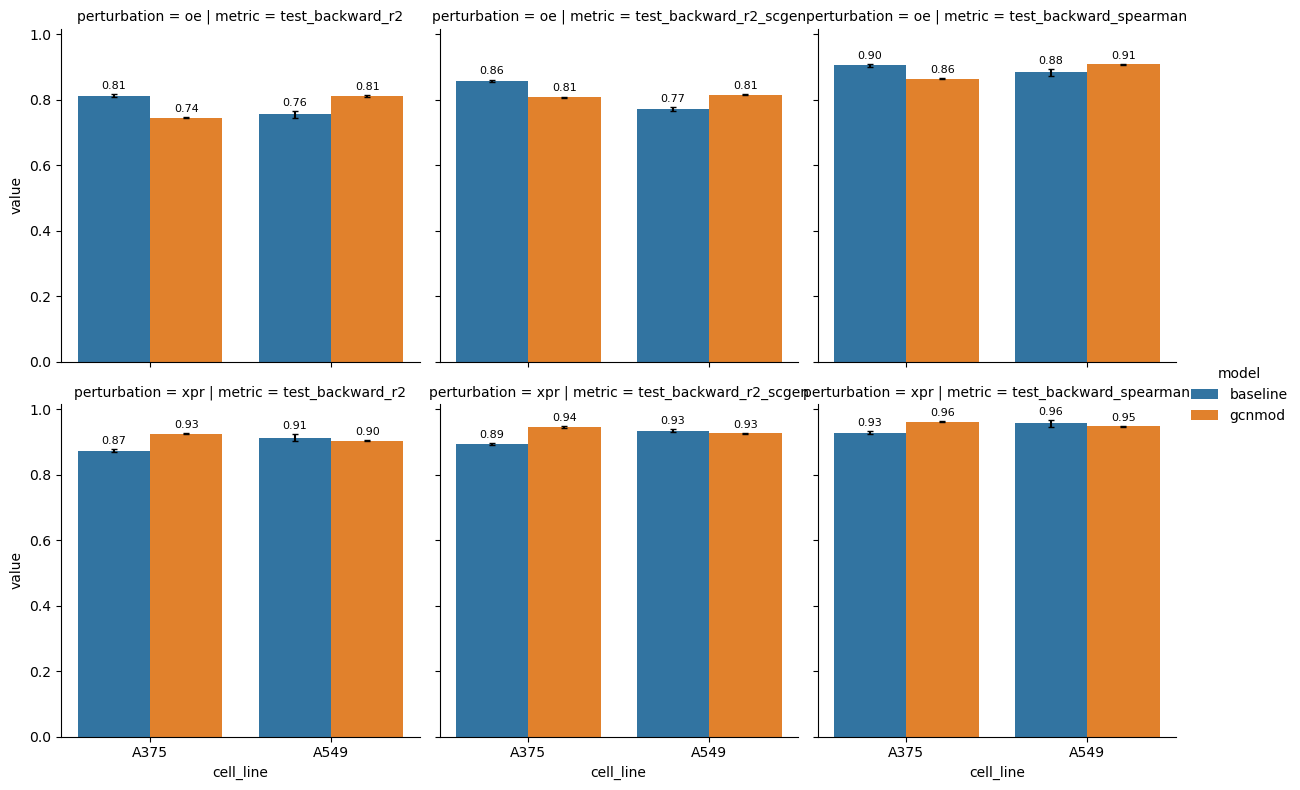

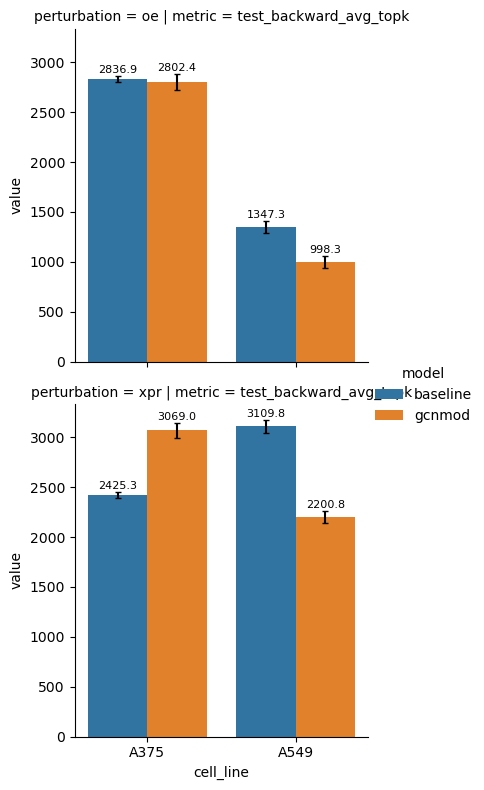

In [98]:
cell_lines = ["A549", "A375"]
project_dir = "/home/b-evelyntong/hl/training_history/report_4_22_again"
out = collect_metrics(project_dir, cell_lines)
df_summary, collapsed_across_celllines = process_metrics(out)

# save some tables
out.to_csv(os.path.join(project_dir, "raw_metrics.csv"), index=False)
df_summary.to_csv(os.path.join(project_dir, "collapsed_across_splits.csv"), index=False)
collapsed_across_celllines.to_csv(os.path.join(project_dir, "collapsed_across_celllines.csv"), index=False)

# plot
df_long = df_summary_stat(df_summary)
plot_metric(df_long, "forward", "train")
plot_metric(df_long, "backward", "train")
plot_metric(df_long, "forward", "test")
plot_metric(df_long, "backward", "test")